## Demonstrating Exploding Gradients

### Introduction

Exploding gradients occur during the training of deep neural networks when gradients grow excessively large during backpropagation. This leads to unstable training, numerical overflow, and diverging loss.

### Why Exploding Gradients Happen

1. **Poor Weight Initialization**: Large initial weights lead to larger activations and gradients.
2. **High Learning Rates**: Large learning rates amplify updates, causing gradients to explode.
3. **Deep Networks**: Many layers amplify the issue due to repeated multiplications of large values.

---

In this notebook, we will:
1. Demonstrate exploding gradients using **vanilla Python** and **PyTorch**.
2. Show techniques to mitigate exploding gradients.


In [1]:
import math
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

In [2]:
def return_data():
    iris = load_iris()
    X = iris.data
    y = iris.target

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    x_train = torch.FloatTensor(X_train_scaled)
    y_train = torch.LongTensor(y_train)
    
    return x_train, y_train


### Exploding Gradients in Vanilla Python

In this example, we simulate exploding gradients by multiplying gradients with a large constant in a deep network.


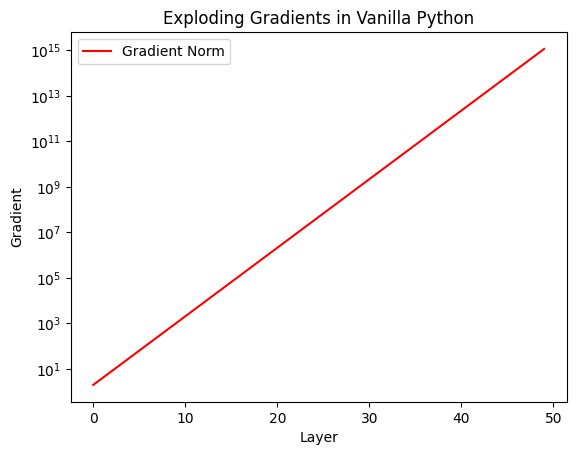

In [3]:
layers = 50  
grad = 1.0  
gradients = []

for _ in range(layers):
    grad *= 2 
    gradients.append(grad)

plt.plot(range(layers), gradients, label="Gradient Norm", color="red")
plt.title("Exploding Gradients in Vanilla Python")
plt.xlabel("Layer")
plt.ylabel("Gradient")
plt.yscale("log") 
plt.legend()
plt.show()


## Mitigating Exploding Gradients

### 1. Gradient Clipping
Gradient clipping limits the magnitude of gradients to prevent them from exploding.

### 2. Proper Weight Initialization
Using initialization methods like **Xavier Initialization** or **He Initialization** ensures weights are scaled appropriately.

### 3. Adaptive Optimizers
Optimizers like **Adam** or **RMSprop** adjust the parameters update dynamically to prevent instability.



### Gradient Clipping in PyTorch

Here, we apply gradient clipping to stabilize training.


In [91]:
x,y = return_data()

In [92]:
class ReluMdl(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 3)
        )
    
    def forward(self, x):
        return self.layers(x)

In [93]:
relu_mdl = ReluMdl()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(relu_mdl.parameters(), lr=0.01)

In [94]:
def clipped_train(mdl):
    '''
    returns mdl, grads
    '''
    grads = []
    loss_gaps = 0
    for epoch in range(500):
        optimizer.zero_grad()
        output = mdl(x)
        loss = criterion(output, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(mdl.parameters(), max_norm=1.0)
        grads.append(mdl.layers[0].weight.grad.norm().item())
        optimizer.step()
        
    print('finished at epoch', epoch)    
    return mdl, grads

In [95]:
clipped_relu, clipped_grads = clipped_train(relu_mdl)

finished at epoch 499


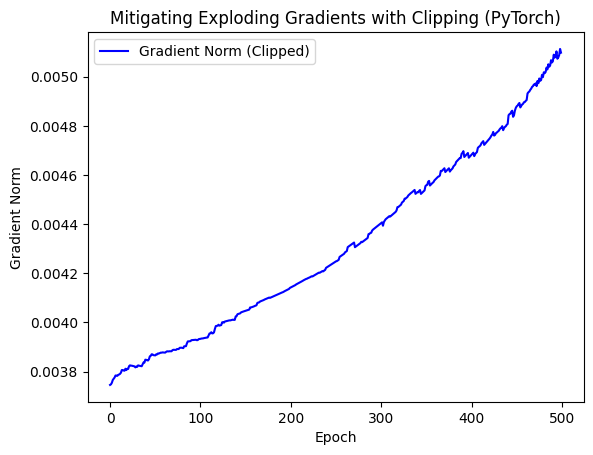

In [96]:
plt.plot(clipped_grads, label="Gradient Norm (Clipped)", color="blue")
plt.title("Mitigating Exploding Gradients with Clipping (PyTorch)")
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.legend()
plt.show()

In [97]:
sum(clipped_grads) / len(clipped_grads)

0.00431776127545163

In [15]:
def calc_acc(mdl):
    score = 0
    for idx, tensor in enumerate(mdl(x)):
        res = tensor.argmax()
        if res == y[idx]:
            score +=1
    avg_score = score / len(x)
    return avg_score

In [99]:
calc_acc(clipped_relu)

0.375

In [8]:
def train_and_return_grads(mdl):
    '''
    returns mdl, grads
    '''
    grads = []
    loss_gaps = 0
    for epoch in range(500):
        optimizer.zero_grad()
        output = mdl(x)
        loss = criterion(output, y)
        loss.backward()
        grad = float(mdl.layers[0].weight.grad.norm().item())
        print(grad)
        if math.isnan(grad) or epoch > 3 and grad == 0:
            print('-' * 100)
            print('learning stops at epoch', epoch)
            return grads
            print('-' * 100)
        grads.append(mdl.layers[0].weight.grad.norm().item())
        optimizer.step()
        
#         if epoch % 100 == 0:
#             print('loss is', loss)
            
    print('Finishing at epoch', epoch)    
    return grads

In [18]:
class ExpldoingReluMdl(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 3)
        )
        
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.uniform_(layer.weight, a=-1, b=1)

    
    def forward(self, x):
        return self.layers(x)

In [19]:
x,y = return_data()

In [20]:
exp_relu_mdl = ExpldoingReluMdl()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(exp_relu_mdl.parameters(), lr=0.1)

In [21]:
exploading_grads = train_and_return_grads(exp_relu_mdl)

28.19628143310547
31.37240982055664
0.0
0.0
0.0
----------------------------------------------------------------------------------------------------
learning stops at epoch 4


This model barely trains, only 4-5 epochs, so it cant be too good.

In [114]:
calc_acc(mdl)

0.3333333333333333

In [10]:
class ExpldoingReluMdl(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 3)
        )
        
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.uniform_(layer.weight, a=-1, b=1)

    
    def forward(self, x):
        return self.layers(x)

## Using Adam Optimizer Helps

In [11]:
x,y = return_data()
exp_relu_mdl = ExpldoingReluMdl()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(exp_relu_mdl.parameters(), lr=0.01)

In [12]:
exploading_grads = train_and_return_grads(exp_relu_mdl)

84.70901489257812
47.02616500854492
23.34588050842285
9.664644241333008
4.99766206741333
5.504772663116455
6.4516377449035645
4.372560501098633
1.945167899131775
1.424826979637146
0.9819455146789551
0.7603700757026672
0.36738961935043335
0.3526667058467865
0.414721816778183
0.3544430732727051
0.4043309986591339
0.4394325315952301
0.490704208612442
0.49830910563468933
1.028010606765747
0.43104124069213867
0.2957424223423004
0.274188756942749
0.5066813826560974
0.2968015968799591
0.15048545598983765
0.2224799245595932
0.23022650182247162
0.3770557940006256
0.7320626974105835
0.7102878093719482
0.4467419385910034
0.1916022002696991
0.2188686579465866
0.239571213722229
0.23003636300563812
0.17455600202083588
0.14690974354743958
0.1374386101961136
0.1358797699213028
0.15707151591777802
0.1558394581079483
0.15967097878456116
0.13930852711200714
0.0924309566617012
0.09215635806322098
0.0808558240532875
0.07758575677871704
0.06945006549358368
0.06288682669401169
0.0654287189245224
0.0722790807

In [17]:
calc_acc(exp_relu_mdl)

1.0

### Why Does Adam Help With Exploding Gradients?

- Adaptive Learning Rates:
Adam computes per-parameter learning rates based on the magnitude of past gradients. This means parameters with large gradients are adjusted with smaller updates, preventing them from "exploding."

- Adam maintains two moving averages:
First moment (mean): Tracks the average gradient values.
Second moment (variance): Tracks the square of gradients, which helps scale down large gradients.